In [1]:
dataset_path = "C:\\Users\\yanis\\OneDrive\\Bureau\\Liv1_dataset"

In [2]:
import os
from PIL import Image
import pandas as pd

image_data = []

for folder in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder)
    
    for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)
            if file == "desktop.ini":
                continue
            with Image.open(file_path) as image:
                image_data.append({
                    "FileName": file,
                    "Width": float(image.size[0]),
                    "Height": float(image.size[1]),
                    "Mode": image.mode,
                    "Category": folder,
                })

    print(f"Le dossier '{folder}' a été lu.")

images = pd.DataFrame(image_data)
images


Le dossier 'Painting' a été lu.
Le dossier 'Photo' a été lu.
Le dossier 'Schematics' a été lu.
Le dossier 'Sketch' a été lu.
Le dossier 'Text' a été lu.


,FileName,Width,Height,Mode,Category
0,painting_00001.jpg,710.0,768.0,RGB,Painting
1,painting_00002.jpg,597.0,561.0,RGB,Painting
2,painting_00003.jpg,750.0,600.0,RGB,Painting
3,painting_00004.jpg,1000.0,490.0,RGB,Painting
4,painting_00005.jpg,429.0,570.0,RGB,Painting
...,...,...,...,...,...
41394,text_09996.jpg,595.0,842.0,RGB,Text
41395,text_09997.jpg,595.0,842.0,RGB,Text
41396,text_09998.jpg,595.0,792.0,RGB,Text
41397,text_09999.jpg,595.0,792.0,RGB,Text


In [3]:
images = pd.DataFrame(image_data)
modes_count = images["Mode"].value_counts().reset_index()
modes_count.columns = ["Mode", "Nombre"]
print("Le modes present dans notre dataset : ")
unique_modes = images["Mode"].unique()
print(unique_modes)
print(modes_count)

Le modes present dans notre dataset : 
['RGB' 'L' 'P' 'CMYK' 'RGBA']
   Mode  Nombre
0   RGB   40297
1     L    1091
2     P       5
3  RGBA       5
4  CMYK       1


In [4]:
#Nombre d'image par categorie
import os

category_names = []
image_counts = []

dataset_dir = os.listdir(dataset_path)

for directory in dataset_dir:
    files=os.listdir(os.path.join(dataset_path, directory))
    image_count = len(list(files))
    category_names.append(directory)
    image_counts.append(image_count)
    print("Nombre d'images dans "+ directory +" :", image_count)

Nombre d'images dans Painting : 10000
Nombre d'images dans Photo : 9993
Nombre d'images dans Schematics : 10001
Nombre d'images dans Sketch : 1406
Nombre d'images dans Text : 10000


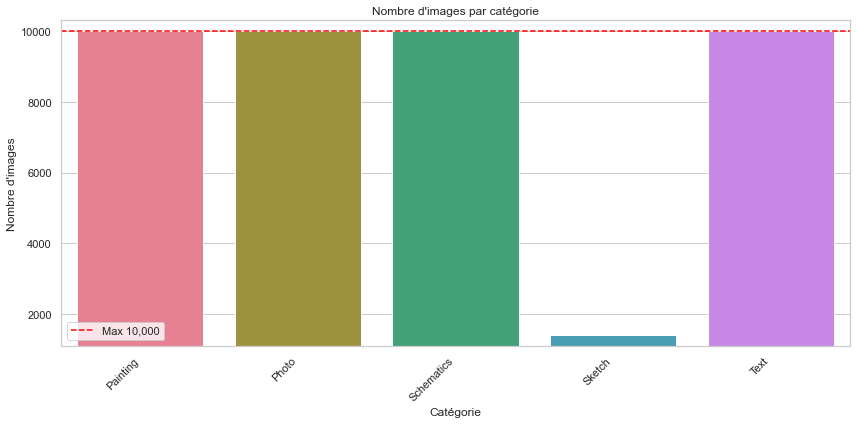

In [5]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
sns.barplot(x=category_names, y=image_counts, palette="husl")
plt.xlabel('Catégorie')
plt.ylabel('Nombre d\'images')
plt.title('Nombre d\'images par catégorie')
plt.xticks(rotation=45, ha="right")

plt.ylim(min(image_counts) - 300, max(image_counts) + 300)

plt.axhline(y=10000, color='red', linestyle='--', label='Max 10,000')

plt.tight_layout()
plt.legend()
plt.show()


In [6]:
#Toutes les extension possibles de notre dataset
import os

extensions = []

for folder in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder)

    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        file_extension = os.path.splitext(file)[1]

        if file_extension not in extensions:
            extensions.append(file_extension)

print("Extensions possibles dans le dataset :")
for extension in extensions:
    print(extension)
    


Extensions possibles dans le dataset :
.jpg
.ini
.png
